In [14]:
#read in data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import numpy as np
import pymc as pm
import arviz as az





def read_data_json(file):
    with open(file) as f:
        data = json.load(f)
    trajectories = {traj['UniqueID']: parse_array(traj['Trajectory']) for traj in data['Trajectories']}
    currents = {traj['UniqueID']: parse_array(traj['Current']) for traj in data['Trajectories']}
    gyro = {traj['UniqueID']: parse_array(traj['Gyro']) for traj in data['Trajectories']}
    accel = {traj['UniqueID']: parse_array(traj['Accel']) for traj in data['Trajectories']}
    angles = {traj['UniqueID']: parse_array(traj['Angles']) for traj in data['Trajectories']}
    return trajectories, currents, gyro, accel, angles

def parse_array(traj):
    return np.array(traj)



In [60]:
positions, currents, gyro, accel, angles = read_data_json('data/TrajectoriesTorso.json')

In [16]:
from collections import defaultdict

# Calculate the average current for specific position and distance to goal
servos = [0, 1]
avg_current_data = {}
for servo in servos:
    current_data = defaultdict(list)
    x, y, z = [], [], []

    for trajectory in currents.keys():
        # Collect data points for starting position and distance to goal
        current_vals = currents[trajectory][:, servo]
        trajectory_vals = positions[trajectory][:, servo]
        goal_pos = trajectory_vals[-1]
        distances_to_goal = np.round(abs(trajectory_vals - goal_pos), 2)

        for pos, dist_to_goal, curr in zip(trajectory_vals, distances_to_goal, current_vals):
            # Convert to int to avoid float precision issues
            pos = int(pos)
            dist_to_goal = int(dist_to_goal)
            current_data[(pos, dist_to_goal)].append(curr)

    servoname = "NeckTilt" if servo == 0 else "NeckPan"
    # Create a DataFrame for each servo
    avg_current_data[servoname] = pd.DataFrame([
        {'Position': pos, 'DistanceToGoal': dist, 'AvgCurrent': np.mean(np.abs(currents))}
        for (pos, dist), currents in current_data.items()
    ])


In [65]:
avg_current_data["NeckPan"]

Position  DistanceToGoal  AvgCurrent
0          192               6   36.960000
1          191               5   48.414545
2          190               4   30.240000
3          189               3   28.332973
4          188               2   34.160000
...        ...             ...         ...
6621       143              86   20.160000
6622       145              84   23.520000
6623       145              83   20.160000
6624       146              82   28.560000
6625       229              15   43.680000

[6626 rows x 3 columns]

In [18]:
#normalize and standardize data
std_avg_current_data = {}
for servo, data in avg_current_data.items():
    dat = data.copy()
    dat['Position'] = (dat['Position'] - dat['Position'].mean()) / dat['Position'].std()
    dat['DistanceToGoal'] = (dat['DistanceToGoal'] - dat['DistanceToGoal'].mean()) / dat['DistanceToGoal'].std()
    dat['AvgCurrent'] = (dat['AvgCurrent'] - dat['AvgCurrent'].mean()) / dat['AvgCurrent'].std()
    std_avg_current_data[servo] = dat

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


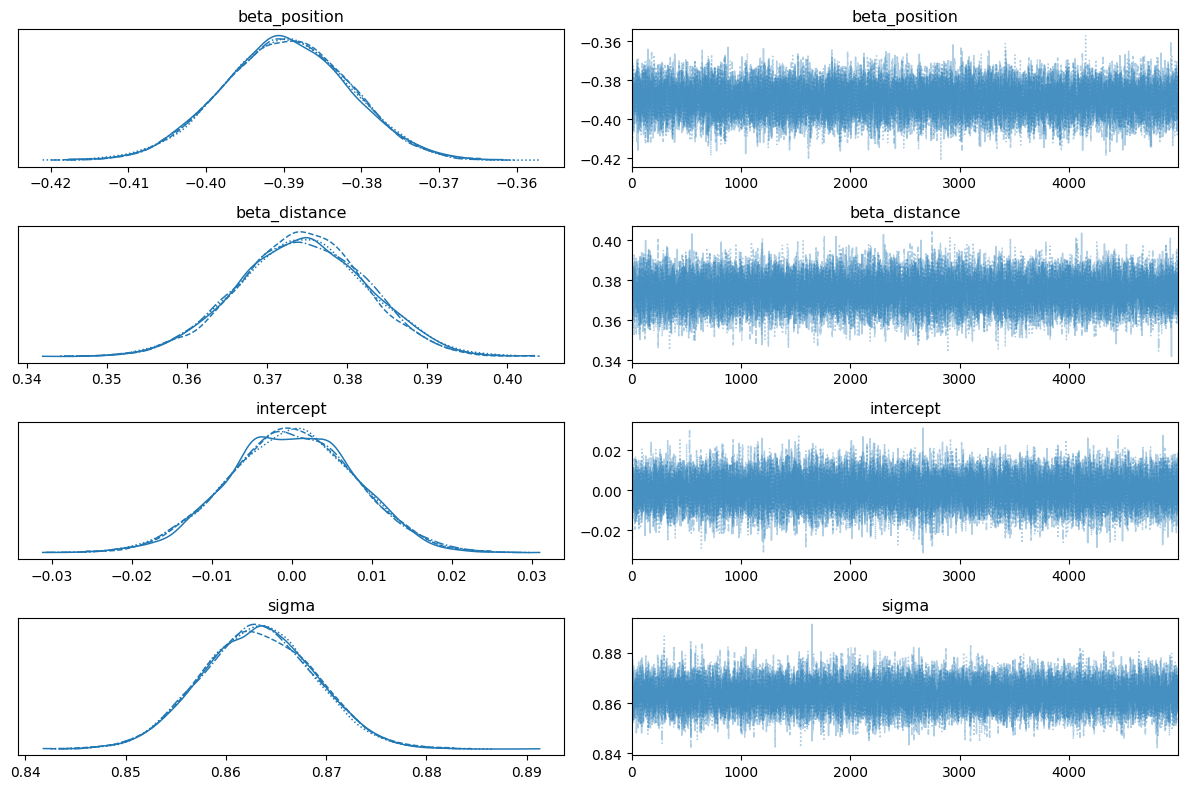

In [19]:


# Define the model
with pm.Model() as regression_tilt_model:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=1)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept + beta_position * std_avg_current_data["NeckTilt"]['Position'] + beta_distance * std_avg_current_data['NeckTilt']['DistanceToGoal']
    
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=std_avg_current_data['NeckTilt']['AvgCurrent'])
    
    # Sample from the posterior
    trace_tilt = pm.sample(5000, tune=1000, return_inferencedata=True)

az.plot_trace(trace_tilt)
plt.tight_layout()
plt.show()

In [21]:
#Posterior Predictive Checks
with regression_tilt_model:
    ppc_tilt = pm.sample_posterior_predictive(trace_tilt)


Sampling: [AvgCurrent]


Output()

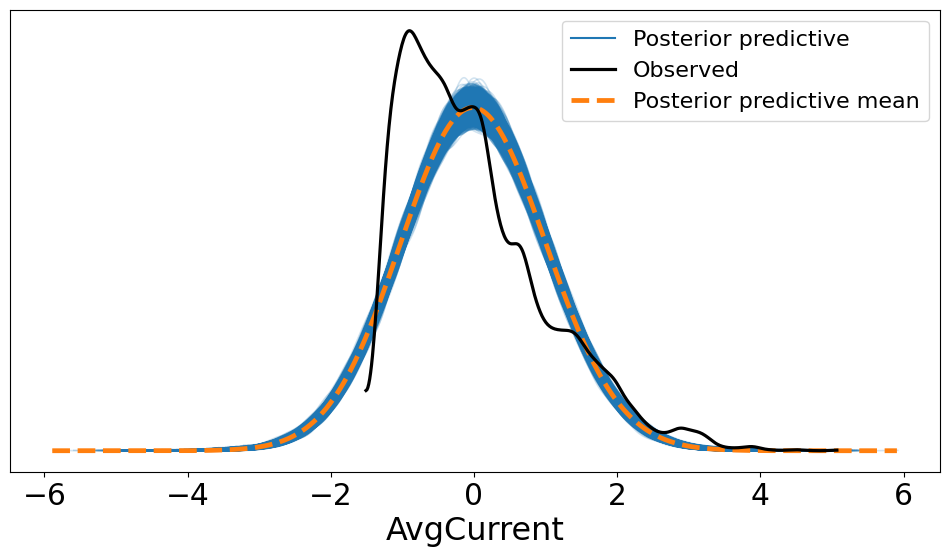

In [22]:
import matplotlib.pyplot as plt
import arviz as az


az.plot_ppc(ppc_tilt, data_pairs={"AvgCurrent": "AvgCurrent"}, figsize=(12, 6))
plt.show()

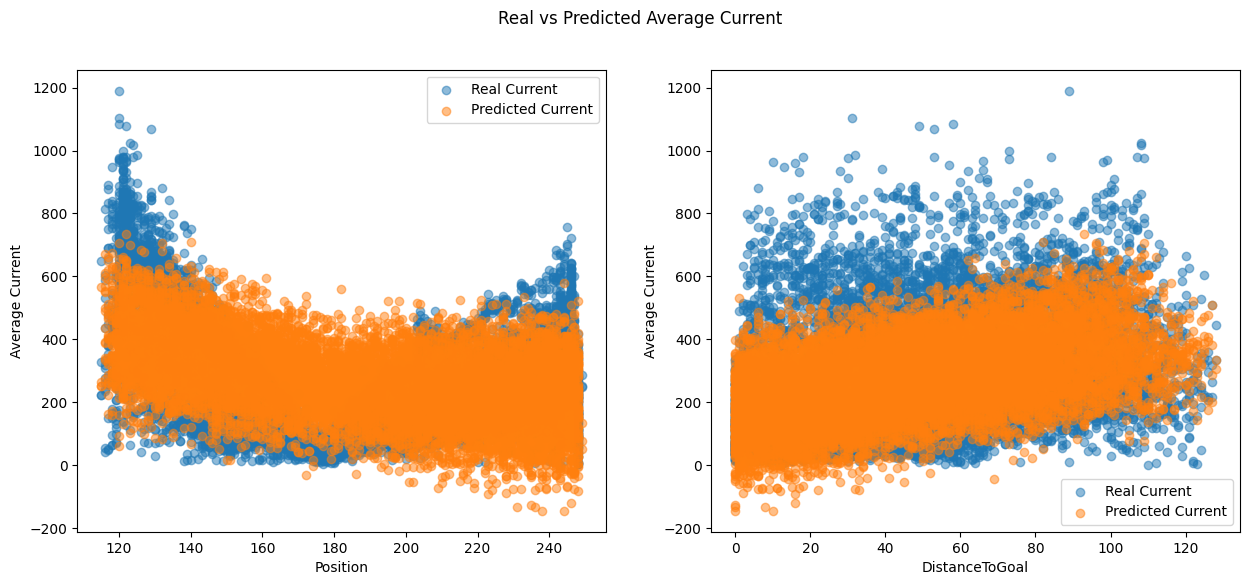

In [23]:
def plot_real_vs_predicted(data, ppc, indep_var='Position'):
    dat = data.copy()
    predicted_current_mean = ppc.posterior_predictive['AvgCurrent'].mean(axis=0)[1]
    avg_current_mean = dat['AvgCurrent'].mean()
    avg_current_std = dat['AvgCurrent'].std()
    predicted_current_raw = predicted_current_mean * avg_current_std + avg_current_mean
    
    if isinstance(indep_var, list):
        fig, axes = plt.subplots(1, len(indep_var), figsize=(15, 6))
        for i, var in enumerate(indep_var):
            axes[i].scatter(data[var], data['AvgCurrent'], alpha=0.5, label='Real Current')
            axes[i].scatter(data[var], predicted_current_raw, alpha=0.5, label='Predicted Current')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Average Current')
            axes[i].legend()
        plt.suptitle('Real vs Predicted Average Current')
    else:
        plt.figure(figsize=(10, 6))
        plt.scatter(data[indep_var], data['AvgCurrent'], alpha=0.5, label='Real Current')
        plt.scatter(data[indep_var], predicted_current_raw, alpha=0.5, label='Predicted Current')
        plt.xlabel(indep_var)
        plt.ylabel('Average Current')
        plt.title('Real vs Predicted Average Current')
        plt.legend()
    plt.show()

plot_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt, indep_var=['Position', 'DistanceToGoal'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


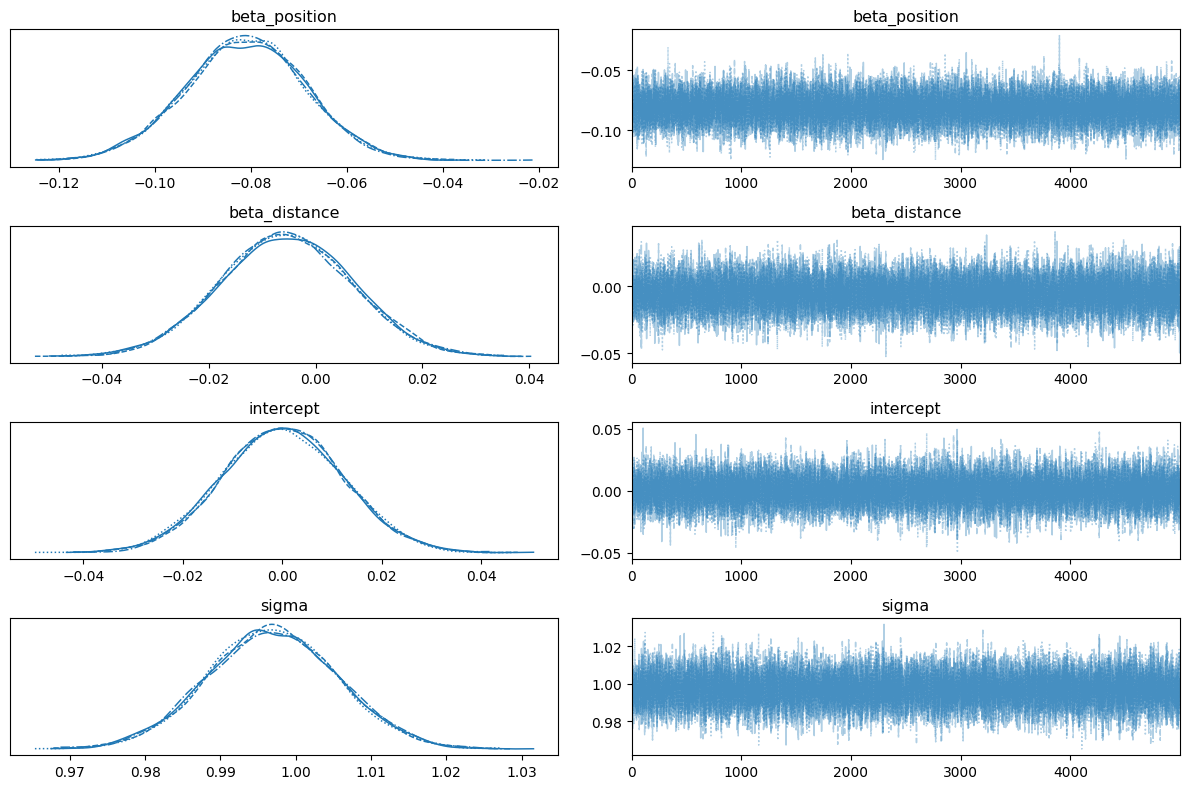

In [24]:
#New model for NeckPan
data = std_avg_current_data["NeckPan"].copy()

with pm.Model() as regression_pan_model:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=1)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept + beta_position * data['Position'] + beta_distance * data['DistanceToGoal']
    
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    # Sample from the posterior
    trace_pan = pm.sample(5000, tune=1000, return_inferencedata=True)

az.plot_trace(trace_pan)
plt.tight_layout()
plt.show()

In [25]:
#Posterior Predictive Checks
with regression_pan_model:
    ppc_pan = pm.sample_posterior_predictive(trace_pan)


Sampling: [AvgCurrent]


Output()

<Axes: xlabel='AvgCurrent'>

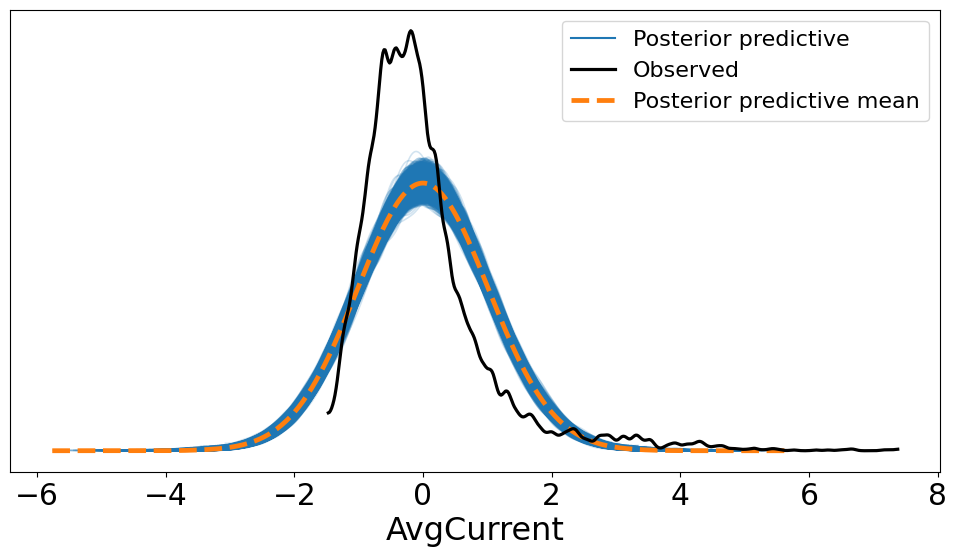

In [26]:
az.plot_ppc(ppc_pan, data_pairs={"AvgCurrent": "AvgCurrent"}, figsize=(12, 6))

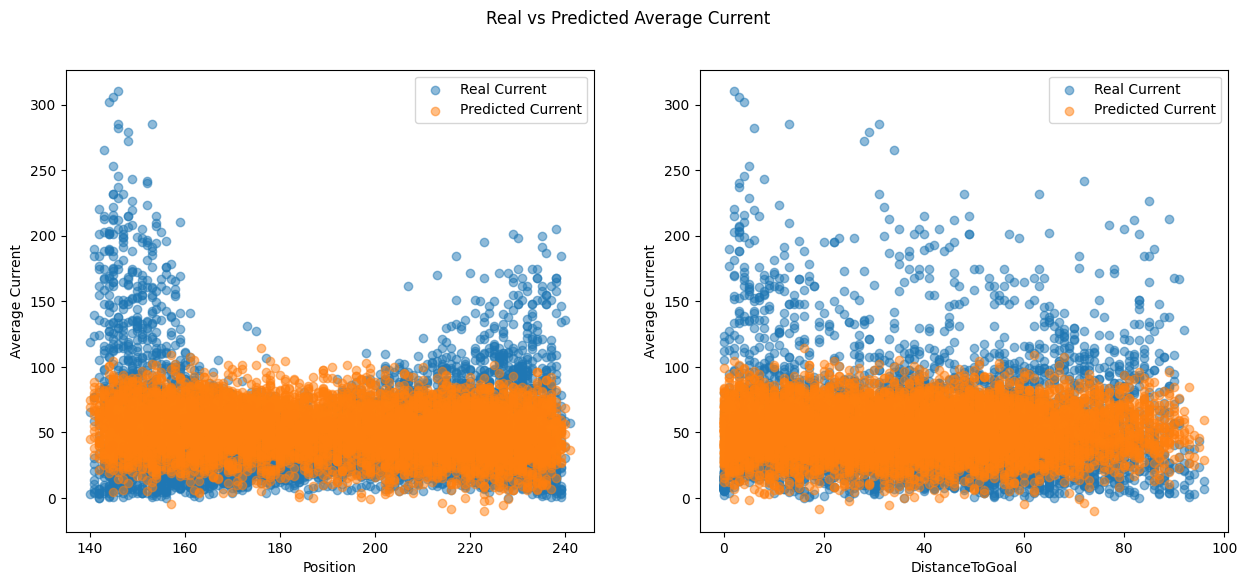

In [27]:

plot_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan, indep_var=['Position', 'DistanceToGoal'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, beta_position2, beta_distance2, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.


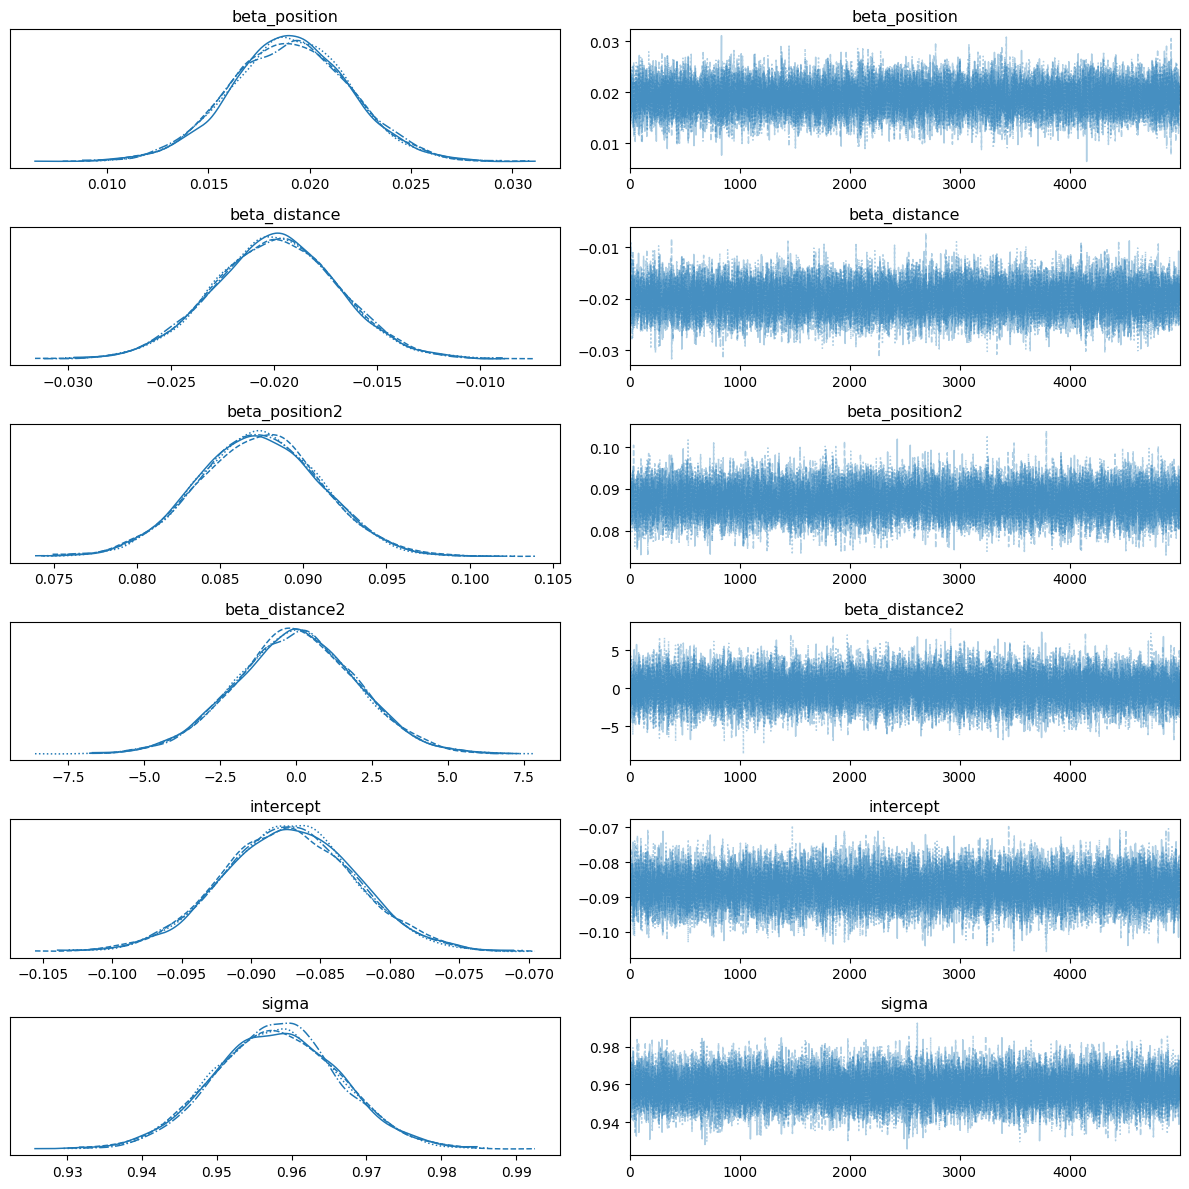

In [46]:
# New polynomial model for NeckPan
data = std_avg_current_data["NeckPan"].copy()

with pm.Model() as regression_pan_model_quadradic:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)
    scalar = 4

    # Linear model equation
    mu = scalar*(intercept - beta_position * data['Position'] + beta_distance * data['DistanceToGoal'] + beta_position2 * data['Position']**2)
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    # Sample from the posterior
    trace_pan_quad = pm.sample(5000, tune=1000, return_inferencedata=True)
az.plot_trace(trace_pan_quad)
plt.tight_layout()
plt.show()

In [47]:
#Posterior Predictive Checks
with regression_pan_model:
    ppc_pan_quad = pm.sample_posterior_predictive(trace_pan_quad)


Sampling: [AvgCurrent]


Output()

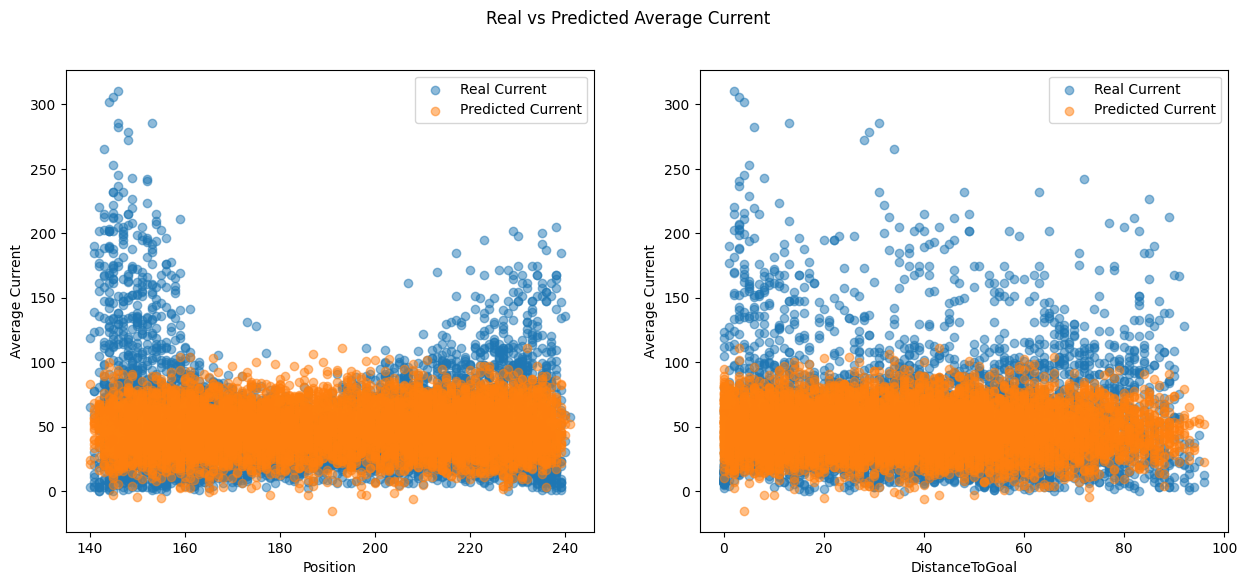

In [48]:
plot_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad, indep_var=['Position', 'DistanceToGoal'])

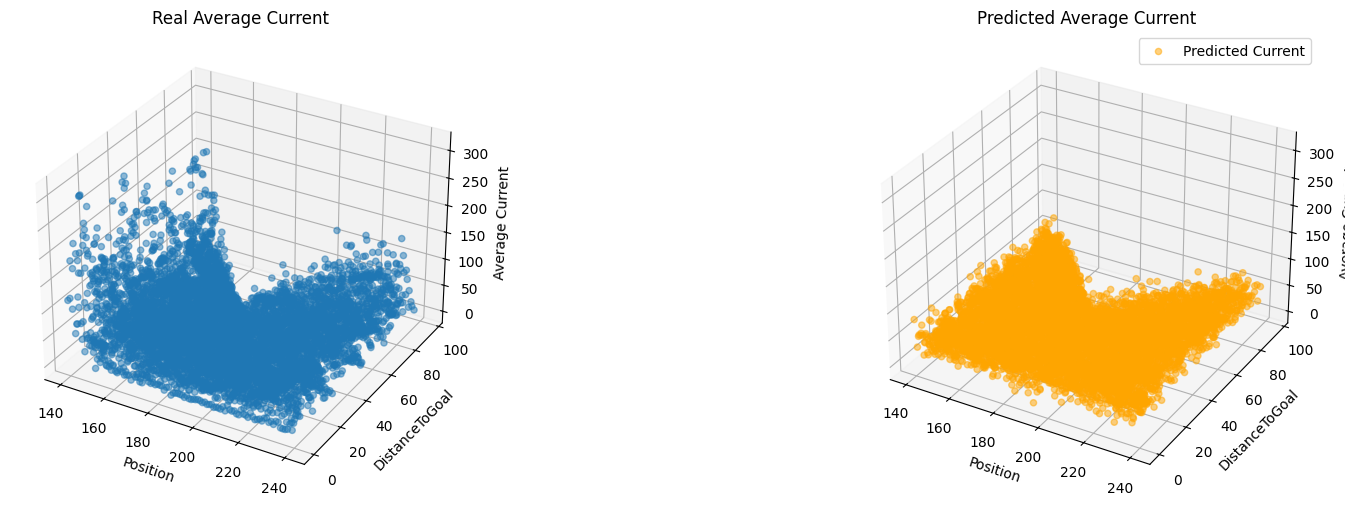

In [49]:
#plot function that plots topographic map in 3d of the real vs predicted values
def plot_3d_real_vs_predicted(data, ppc, indep_var=['Position', 'DistanceToGoal']):
    dat = data.copy()
    predicted_current_mean = ppc.posterior_predictive['AvgCurrent'].mean(axis=0)[1]
    avg_current_mean = dat['AvgCurrent'].mean()
    avg_current_std = dat['AvgCurrent'].std()
    predicted_current_raw = predicted_current_mean * avg_current_std + avg_current_mean
    
    fig = plt.figure(figsize=(20, 6))
    
    # Real Current subplot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(dat[indep_var[0]], dat[indep_var[1]], dat['AvgCurrent'], alpha=0.5, label='Real Current')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('DistanceToGoal')
    ax1.set_zlabel('Average Current')
    ax1.set_title('Real Average Current')
    
    # Predicted Current subplot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(dat[indep_var[0]], dat[indep_var[1]], predicted_current_raw, alpha=0.5, label='Predicted Current', color='orange')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('DistanceToGoal')
    ax2.set_zlabel('Average Current')
    ax2.set_title('Predicted Average Current')
    
    # Set the same axis limits for both subplots
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_zlim(ax1.get_zlim())
    
    plt.legend()
    plt.tight_layout
    plt.show()

plot_3d_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad, indep_var=['Position', 'DistanceToGoal'])

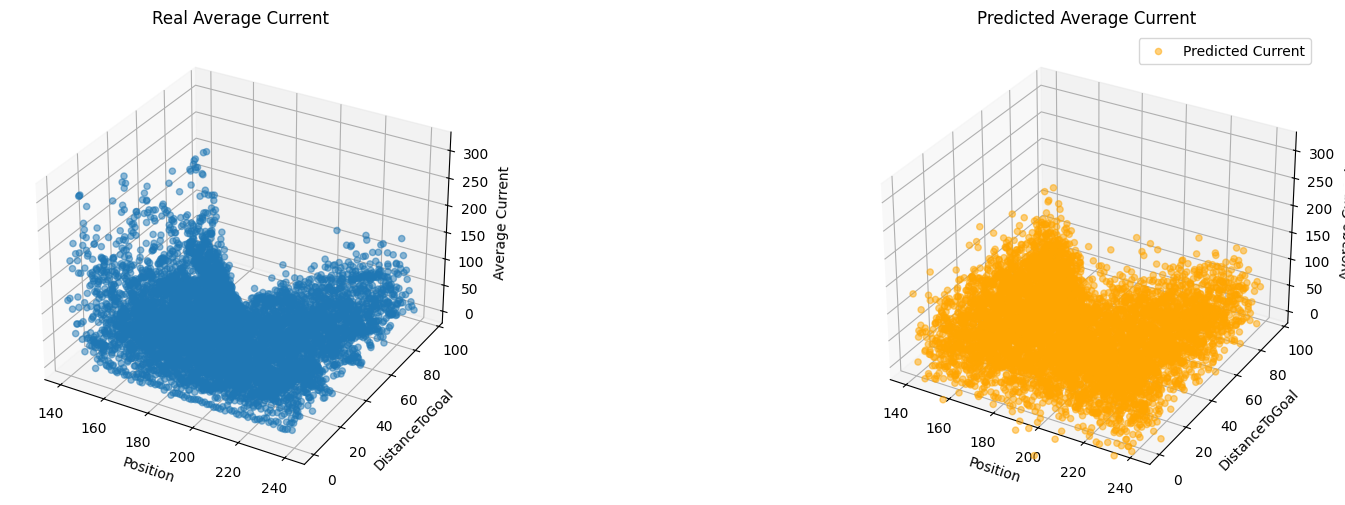

In [50]:
ppc_pan_quad_scaled = ppc_pan_quad.copy()
ppc_pan_quad_scaled.posterior_predictive['AvgCurrent']*=2.5

plot_3d_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad_scaled, indep_var=['Position', 'DistanceToGoal'])

In [33]:
#Qudratic model for NeckTilt
data = std_avg_current_data["NeckTilt"].copy()

with pm.Model() as regression_tilt_model_quadradic:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept - beta_position * data['Position'] + beta_distance * data['DistanceToGoal'] + beta_position2 * data['Position']**2
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    # Sample from the posterior
    trace_tilt_quad = pm.sample(5000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, beta_position2, beta_distance2, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


In [34]:
with regression_tilt_model_quadradic:
    ppc_tilt_quad = pm.sample_posterior_predictive(trace_tilt_quad)

Sampling: [AvgCurrent]


Output()

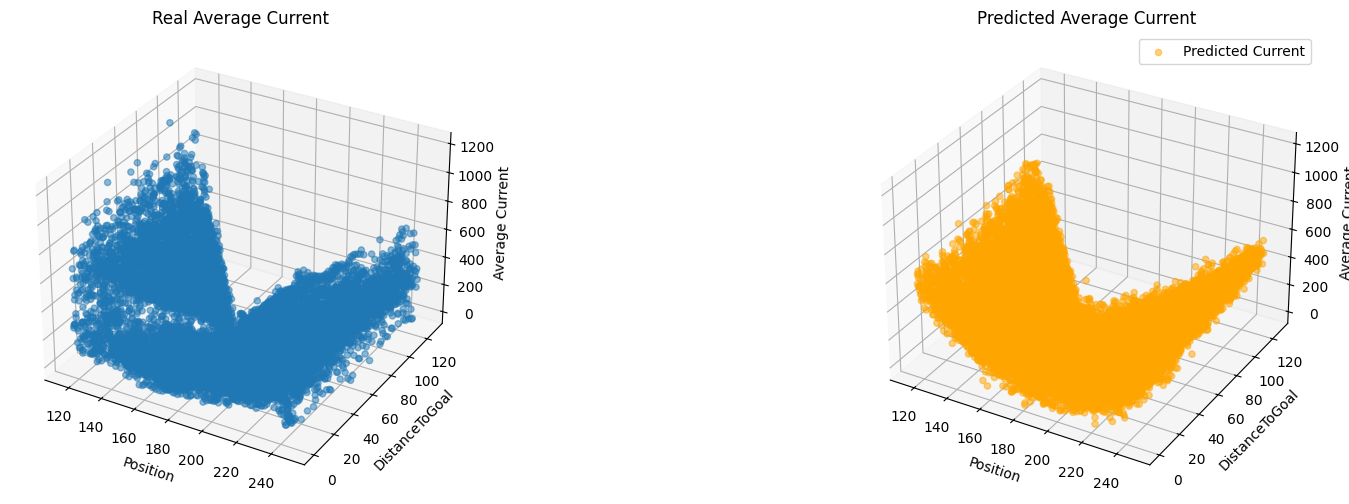

In [35]:
plot_3d_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt_quad, indep_var=['Position', 'DistanceToGoal'])

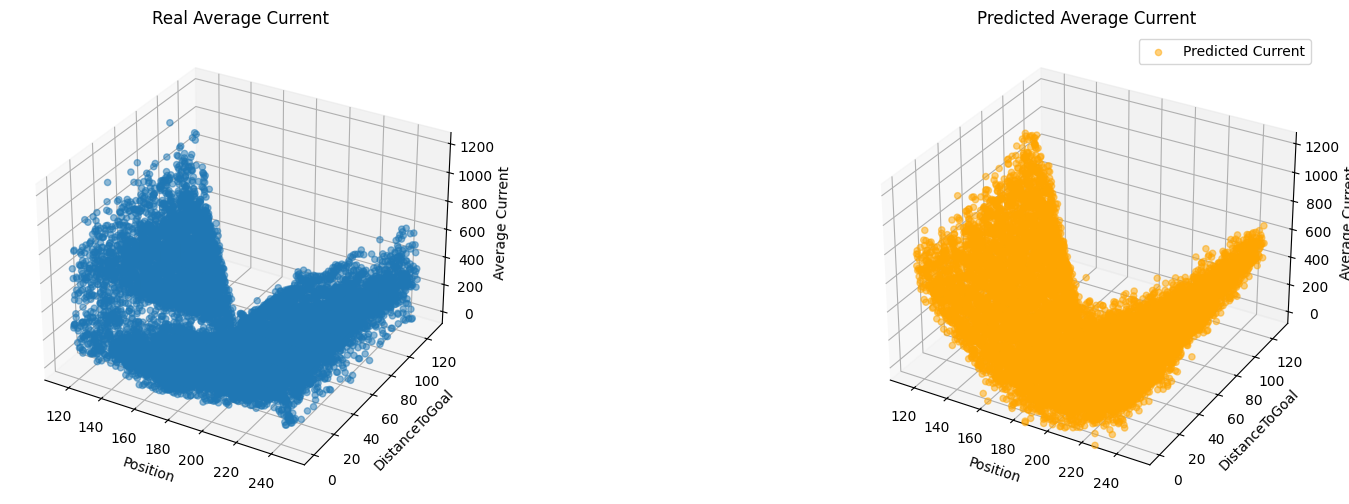

In [36]:
ppc_tilt_quad_scaled = ppc_tilt_quad.copy()
ppc_tilt_quad_scaled.posterior_predictive['AvgCurrent']*=1.4

plot_3d_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt_quad_scaled, indep_var=['Position', 'DistanceToGoal'])

In [41]:
tilt_model_comparison = az.compare({'tilt': trace_tilt, 'tilt_quad': trace_tilt_quad}, ic='waic')

In [42]:
tilt_model_comparison

rank     elpd_waic    p_waic    elpd_diff    weight          se  \
tilt_quad     0 -11424.304427  7.354582     0.000000  0.943925  105.351503   
tilt          1 -14942.538767  4.660799  3518.234341  0.056075   86.341150   

                 dse  warning scale  
tilt_quad   0.000000    False   log  
tilt       92.009209    False   log

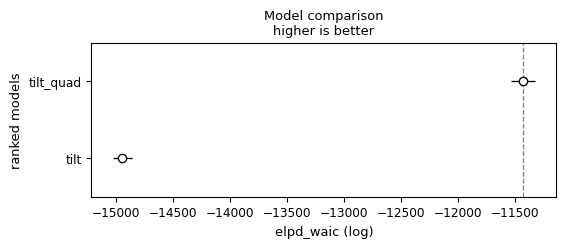

In [44]:
az.plot_compare(tilt_model_comparison)
plt.show()

In [56]:
with regression_pan_model:
    pm.compute_log_likelihood(trace_pan)

with regression_pan_model_quadradic:
    pm.compute_log_likelihood(trace_pan_quad)


Output()

In [57]:

pan_model_comparison_WAIC = az.compare({'pan': trace_pan, 'pan_quad': trace_pan_quad}, ic='waic')

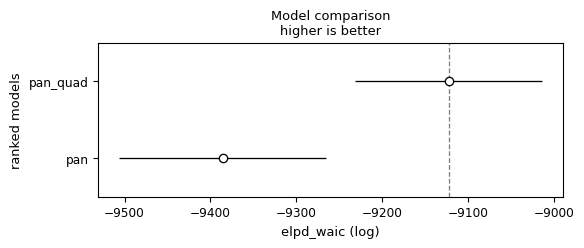

In [59]:
az.plot_compare(pan_model_comparison_WAIC)
plt.show()

<Axes: xlabel='AvgCurrent'>

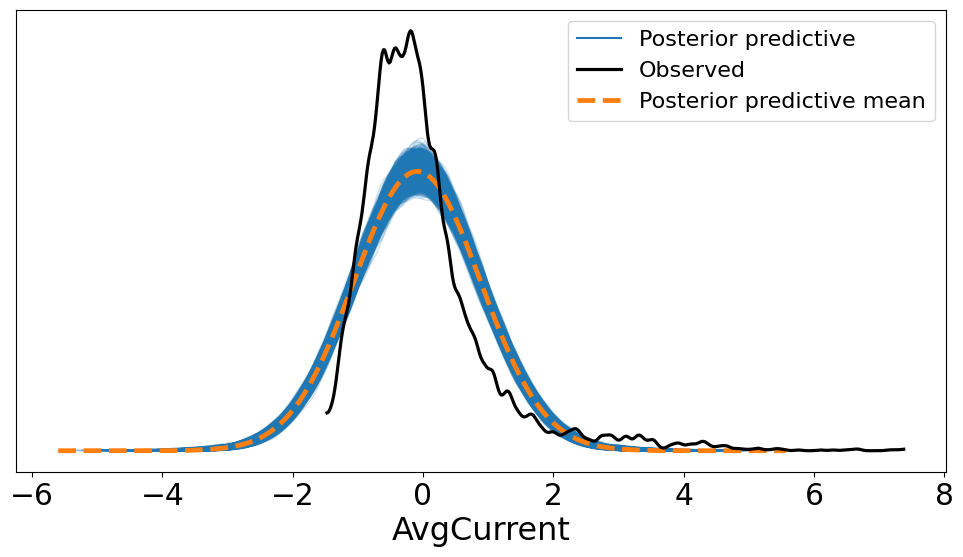

In [61]:
az.plot_ppc(ppc_pan_quad, data_pairs={"AvgCurrent": "AvgCurrent"}, figsize=(12, 6))

In [63]:
std_avg_current_data

{'NeckTilt':        Position  DistanceToGoal  AvgCurrent
 0     -0.269615       -1.021002   -1.256306
 1     -0.294766       -1.021002   -1.203976
 2     -0.294766       -1.054503   -1.203502
 3     -0.319918       -1.054503   -1.203825
 4     -0.319918       -1.088003   -1.247987
 ...         ...             ...         ...
 11742 -1.577497        0.453011    0.780691
 11743 -1.552345        0.453011    2.936016
 11744 -1.552345        0.419511    2.856961
 11745 -1.527194        0.386011    2.094311
 11746 -1.376284        0.218509    1.220055
 
 [11747 rows x 3 columns],
 'NeckPan':       Position  DistanceToGoal  AvgCurrent
 0     0.055144       -1.334881   -0.424789
 1     0.020352       -1.378077   -0.097824
 2    -0.014440       -1.421272   -0.616609
 3    -0.049232       -1.464468   -0.671044
 4    -0.084024       -1.507663   -0.504714
 ...        ...             ...         ...
 6621 -1.649660        2.120757   -0.904339
 6622 -1.580076        2.034366   -0.808429
 6623 -1.580

In [91]:
# Combine the data to a dataframe 
all_data = pd.DataFrame()

for key in positions.keys():
    temp_data = pd.DataFrame()
    temp_data['tilt_pos'] = positions[key][:,0]
    temp_data['pan_pos'] = positions[key][:,1]
    temp_data['tilt_current'] = currents[key][:,0]
    temp_data['pan_current'] = currents[key][:,1]
    temp_data['gyro_x'] = gyro[key][:,0]
    temp_data['gyro_y'] = gyro[key][:,1]
    temp_data['gyro_z'] = gyro[key][:,2]
    temp_data['accel_x'] = accel[key][:,0]
    temp_data['accel_y'] = accel[key][:,1]
    temp_data['accel_z'] = accel[key][:,2]
    temp_data['tilt_distance'] = np.abs(positions[key][:,0] - positions[key][-1,0])
    temp_data['pan_distance'] = np.abs(positions[key][:,1] - positions[key][-1,1])
    all_data = pd.concat([all_data, temp_data], ignore_index=True)



In [102]:
import os


# Define the file path for saving the trace
trace_file = 'trace_tilt_quad_all.nc'

# Check if the trace file exists
if os.path.exists(trace_file):
    # Load the existing trace
    trace_tilt_quad_all = az.from_netcdf(trace_file)
else:
    # New tilt quadric model using all the data
    data = all_data.copy()

    with pm.Model() as regression_tilt_model_quadradic_all:
        # Priors for the regression coefficients (assuming normal priors)
        beta_position = pm.Normal('beta_position', mu=0, sigma=2)
        beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
        beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
        beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)

        # Prior for the intercept
        intercept = pm.Normal('intercept', mu=0, sigma=1)

        # Prior for the error term
        sigma = pm.HalfNormal('sigma', sigma=1)

        # Linear model equation
        mu = intercept - beta_position * data['tilt_pos'] + beta_distance * data['tilt_distance'] + beta_position2 * data['tilt_pos']**2

        # Likelihood (observed data is normally distributed around mu)
        likelihood = pm.Normal('tilt_current', mu=mu, sigma=sigma, observed=data['tilt_current'])

        # Sample from the posterior
        trace_tilt_quad_all = pm.sample(3000, tune=1000, return_inferencedata=True)

        # Save the trace to a file
        az.to_netcdf(trace_tilt_quad_all, trace_file)

# Summarize the trace
az.summary(trace_tilt_quad_all)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, beta_position2, beta_distance2, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5214 seconds.


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_position    -7.149  0.014   -7.175   -7.122      0.000    0.000   
beta_distance     2.917  0.009    2.899    2.933      0.000    0.000   
beta_position2   -0.040  0.000   -0.040   -0.040      0.000    0.000   
beta_distance2   -0.011  1.995   -3.767    3.715      0.022    0.020   
intercept        62.026  0.985   60.171   63.848      0.013    0.009   
sigma           256.587  0.197  256.222  256.963      0.002    0.001   

                ess_bulk  ess_tail  r_hat  
beta_position     4344.0    5251.0    1.0  
beta_distance     7942.0    7651.0    1.0  
beta_position2    4789.0    5892.0    1.0  
beta_distance2    7891.0    7394.0    1.0  
intercept         5383.0    6948.0    1.0  
sigma             8823.0    7842.0    1.0

In [98]:
#Model with both tilt and pan allowing for interaction of position
data = all_data.copy()

with pm.Model() as regression_tilt_pan_model:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position_tilt = pm.Normal('beta_position_tilt', mu=0, sigma=1)
    beta_distance_tilt = pm.Normal('beta_distance_tilt', mu=0, sigma=1)
    beta_position_pan = pm.Normal('beta_position_pan', mu=0, sigma=1)
    beta_distance_pan = pm.Normal('beta_distance_pan', mu=0, sigma=1)
    beta_position_interaction = pm.Normal('beta_position_interaction', mu=0, sigma=1)
    beta_distance_interaction = pm.Normal('beta_distance_interaction', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    
    
    # Linear model equation
    mu_tilt = intercept + beta_position_tilt * data['tilt_pos'] + beta_distance_tilt * data['tilt_distance'] +  beta_position_interaction * data['tilt_pos'] * data['pan_pos'] + beta_distance_interaction * data['tilt_distance'] * data['pan_distance']
    # Likelihood (observed data is normally distributed around mu)
    likelihood_tilt = pm.Normal('TiltCurrent', mu=mu_tilt, sigma=sigma, observed=data['tilt_current'])

    mu_pan = intercept + beta_position_tilt * data['tilt_pos'] + beta_position_pan * data['pan_pos'] + beta_distance_pan * data['pan_distance'] + beta_position_interaction * data['tilt_pos'] * data['pan_pos'] + beta_distance_interaction * data['tilt_distance'] * data['pan_distance']
    likelihood_pan = pm.Normal('PanCurrent', mu=mu_pan, sigma=sigma, observed=data['pan_current'])
    
    # Sample from the posterior
    trace_tilt_pan = pm.sample(3000, tune=1000, return_inferencedata=True)

az.summary(trace_tilt_pan)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position_tilt, beta_distance_tilt, beta_position_pan, beta_distance_pan, beta_position_interaction, beta_distance_interaction, intercept, sigma]


Output()

ValueError: Not enough samples to build a trace.